## Explore House Prices in King County, WA

Sample R-Notebook showcasing use of R-ArcGIS Bridge functionality with R-Notebooks. This notebook summarizes.

1. Working with remote data sources(Feature Services)
2. Vector data conversion & manipulation
3. Working with `arcpy`
4. Getting Help from Documentation

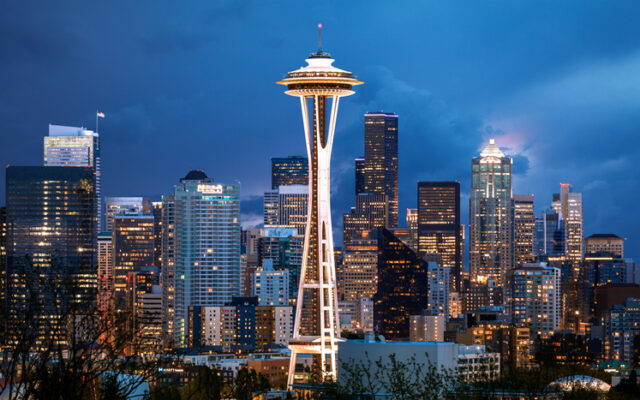

### Dataset

The dataset used is the King County, WA house prices that include house sale prices in King County, WA in addition to attributes of homes including:
1. Number of Bedrooms
2. Number of Bathrooms
3. Living Space Square-footage
4. Total Lot Square Footage
5. Building Grade
6. Waterfront

and others.



### Importing Necessary R libraries
Import necessary R libraries for the workflow.`arcgisbinding` is the R-ArcGIS Bridge that enables:
- Interactive mapping
- Reading spatial data from ESRI platform (all supported feature classes and rasters)
- Projecting spatial data on-the-fly
- Writing spatial data back to geodatabase, external rasters and shapefiles
- __Logging Into Portals to Reach Private Remote Data__
- __Interactive mapping__

In [1]:
library(arcgisbinding)
library(leaflet)
library(leaflet.esri)
library(raster)
library(reticulate)

*** Please call arc.check_product() to define a desktop license.
Loading required package: leaflet.extras
Loading required package: sp


### Connect to a valid license of ArcGIS Pro
`arc.check_product()` connects to a valid license of ArcGIS Pro. This function is __mandatory__ because without a valid ArcGIS Pro license none of the `arcgisbinding` functionality works.

`arc.check_product()` defines:
- The version of ArcGIS Pro
- Type of ArcGIS Pro license
- Version of `arcgisbinding`

In [2]:
arc.check_product()

product: ArcGIS Pro (13.1.0.41833)
license: Advanced
version: 1.0.1.300

#### Importing `arcpy`

The new integration with `reticulate` allows bringing in `arcpy` to the R instance. This functionality enables calling Geoprocessing tools from an R notebook

In [3]:
reticulate::use_python('Your/Conda/env/PYTHON', required = T)
ARCPY <- import('arcpy')

#### Connecting to Portal

You can sign in to the portal with `arc.portal_connect`.

- If you are already signed in ArcGIS Pro, `arc.portal_connect` will connect to the portal without login information
- If you are not signed in to the portal in ArcGIS Pro, you can provide your login details

In [7]:
arc.check_portal()

*** Current
  url		: https://www.arcgis.com/
  version	: 10.2
  user		: Orhun7
  organization	: GP Analysis - Prod Hive 3
*** Not signed in
  'https://dredd29.esri.com/portal/'
  'https://gpportal.esri.com/portal/'

#### Reading Remote Data in a Portal

Housing data for King County, WA is stored in a Feature Service. Using `arc.open()` we can seamlessly read in this dataset. First check if you are logged in to the portal. Using a new function called `arc.check_product()`.

__Note__: You can only login to portals that your Pro instance is aware of.

#### Reading in Remote Data: Feature Service

Once you are logged in, you can read data with `arc.open`

In [4]:
#### Read a Feature Service that Contains King County Housing Data
feature_service <- 'https://services3.arcgis.com/oZfKvdlWHN1MwS48/arcgis/rest/services/King_County_House_Prices/FeatureServer/0'
arc.fs <- arc.open(feature_service)
house.price <- arc.select(arc.fs)

#### Converting Data to Spatial R Data Structures
`arc.data2sf` and `arc.data2sp` allow converting feature service and feature classes to spatial data frame types recognized by R language. `sf` and `sp` are frequently used spatial data structures in R.

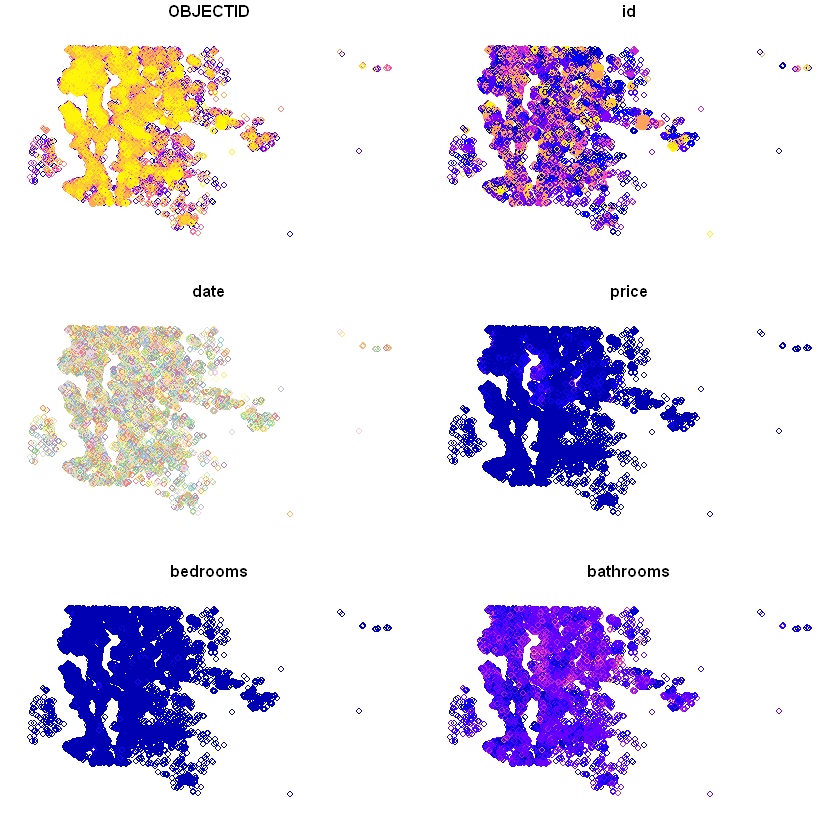

In [5]:
house.price.sf <- arc.data2sf(house.price)
plot(house.price.sf, max.plot = 6)

#### What about interactive mapping?

Static maps are useful. Telling interactive stories are now possible with the R-ArcGIS Bridge.

In [6]:
renderer <- colorQuantile("RdYlBu", domain=house.price$price, reverse=T, probs=c(0, 0.25, 0.5, 0.75, 1))

L<-leaflet(elementId='WA_map') %>%
  addProviderTiles(providers$Esri) %>%
  addCircleMarkers(data = house.price, 
                   color=~renderer(price), 
                   radius=5, 
                   label=~sprintf("Home Price: %s", price)) %>%

  addLegend(pal = renderer, values = house.price$price, title = "Home Price")
L

HTML widgets cannot be represented in plain text (need html)

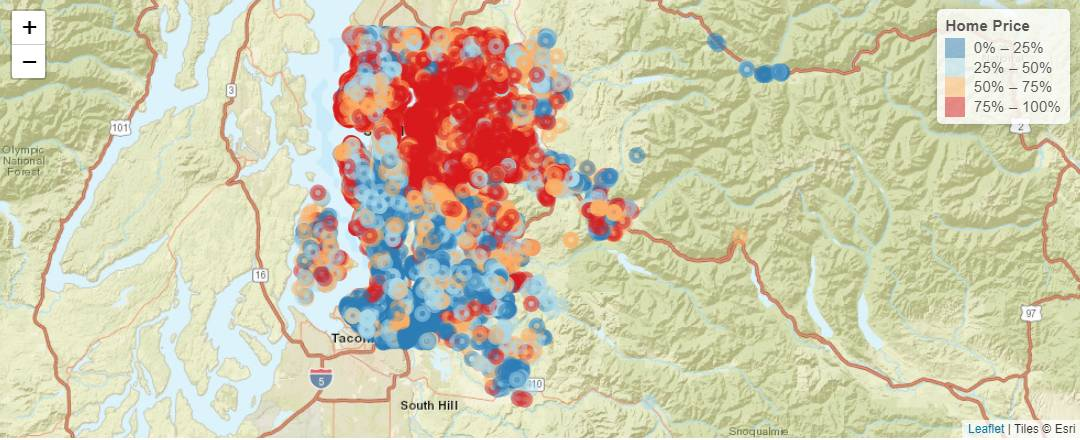

## Leverage ArcPY from R Notebooks

Next, we will create a kriging interpolation model to map price variations in King County, WA. The ideal Geoprocessing tool for this purpose is [Empirical Bayesian Kriging](https://pro.arcgis.com/en/pro-app/help/analysis/geostatistical-analyst/what-is-empirical-bayesian-kriging-.htm).

R Notebooks allow you to leverage Geoprocessing tools directly from R Notebooks.

### Checking Out Licenses

EBK requires the Geostatistics extension. Thanks to ArcPy integration we can seamlessly check out licenses to perform tasks with ArcPy.

In [7]:
#### Checkout GeoStats Extension required for EBK
ARCPY$CheckOutExtension("GeoStats")

[1] "CheckedOut"

In [8]:
getwd()

[1] "C:/Users/ste11653/OneDrive - Esri/Preconference Seminar_devSummit2023/notebooks"

### Setting Environment Variables

Next, we will create a scratch geodatabase to store our results in. We will set the environment workspace to this geodatabase after it is created.

In [13]:
gdb.name <- ARCPY$management$CreateFileGDB(getwd(), "scratchGDB", "CURRENT")
ARCPY$env$workspace <- gsub("\\\\", "/", gdb.name)
ARCPY$env$overwriteOutput = TRUE

### Running Geoprocessing Tools

Running Geoprocessing tools from the R notebook is a breeze. Simply copy your Python command and paste it onto your notebook. With a few syntax changes your code is ready to be run!

In [9]:
ARCPY$ga$EmpiricalBayesianKriging(feature_service, "price", NULL, 'in_memory/price_raster', 
                                  0.0025, "NONE", 100, 1, 100, 
                                  "NBRTYPE=StandardCircular RADIUS=0.338759399316101 ANGLE=0 NBR_MAX=15 NBR_MIN=10 SECTOR_TYPE=ONE_SECTOR", 
                                  "PREDICTION", 0.5, "EXCEED", NULL, "POWER")

### In Memory Features

Our R Notebook honors geoprocessing conventions in the platform such as in memory features. In the previous step we created an in memory raster. Next we will read this in_memory raster output of EBK to an R raster for further visualization.

In [10]:
price.arc.raster <- arc.raster(arc.open('in_memory/price_raster'), sr = 2926)

### Static Raster Plots
Through our raster integration, we can convert any raster dataset to R rasters for analysis and visualization in R

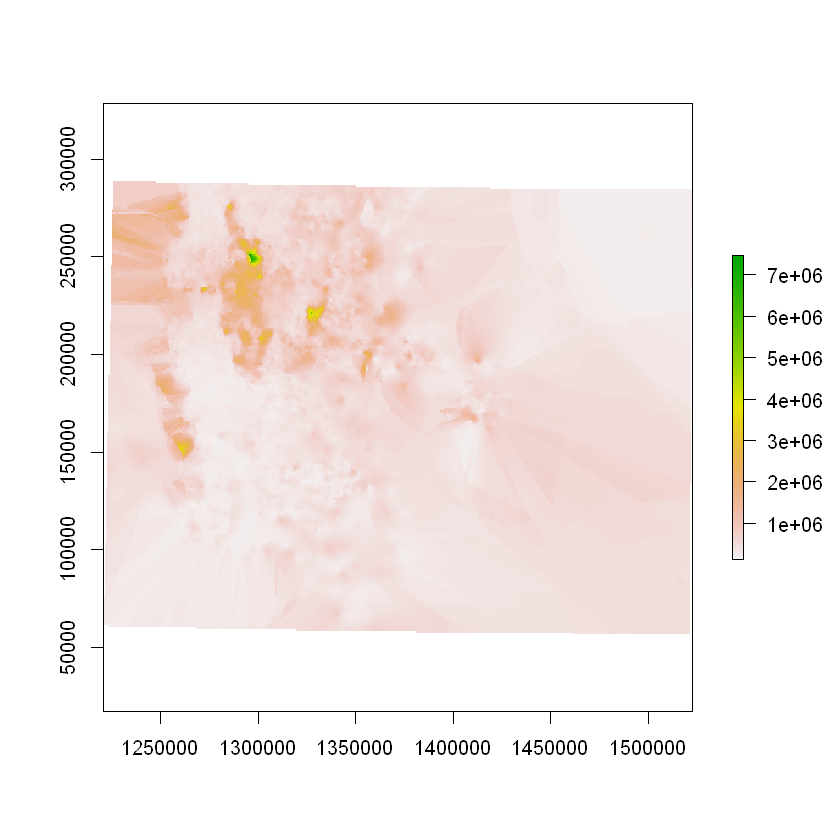

In [11]:
price.R.raster <- as.raster(price.arc.raster)
plot(price.R.raster)

## Interactive Raster Mapping

R raster plots are informative, we can do better with interactive raster mapping with new enhancements to the R-ArcGIS Bridge.
We will use the in memory raster output from EBK and display it.

In [12]:
raster.renderer <- colorNumeric("RdYlBu", domain=values(price.R.raster), na.color = "transparent")
crs(price.R.raster) <- CRS('+init=EPSG:2926')

L2 <-leaflet(elementId='WA_raster') %>%
  addProviderTiles(providers$Esri) %>%
  addRasterImage(price.R.raster, color= raster.renderer) %>%
  addLegend(pal = raster.renderer, values = values(price.R.raster), title = "Interpolated Home Price")
L2

HTML widgets cannot be represented in plain text (need html)

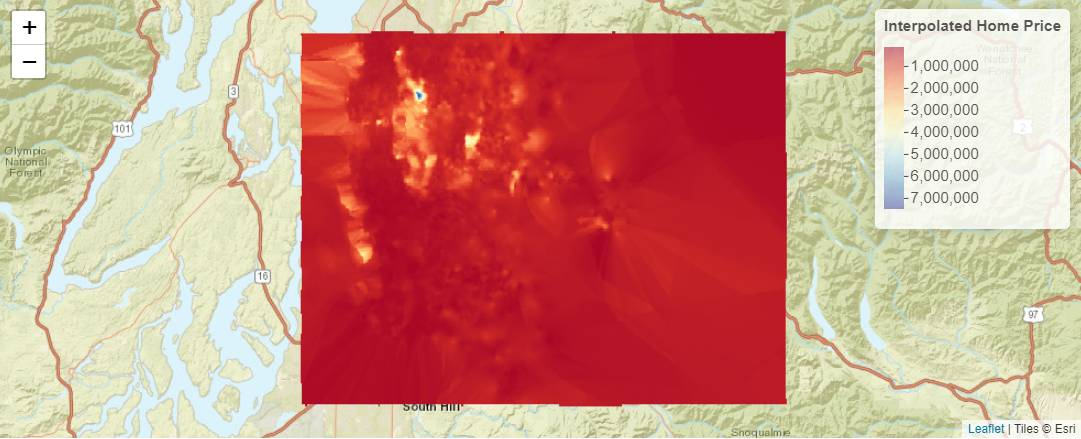

### Local Data I/O & Documentation

#### Sometimes we make mistakes writing code
New enhancements to the R-ArcGIS Bridge works in tandem with local data access. As a last step to our analysis, we will save the result raster in the local geodatabase we created

In [17]:
arc.write(price.arc.raster, file.path(ARCPY$env$workspace, "price_raster"))

ERROR: Error in arc.write(price.arc.raster, file.path(ARCPY$env$workspace, "price_raster")): is.character(path) is not TRUE


#### `arcgisbinding` documentation is fully integrated

Our `arc.write` function failed. We need the documentation to make sure our input order is correct. Luckily R notebooks integrate seamlessly with our documentation 

Now that we have observed the right coding pattern, let's go ahead and save our output raster.

In [18]:
? arc.write

In [ ]:
arc.write(file.path(ARCPY$env$workspace, "price_raster"), price.arc.raster)